# Subscriber Behavior Analysis at Megaline

## Table of Contents <a id='back'></a>
* [Introduction](#intro)
* [Data Preparation](#prep)
* [Model Development](#develop)
* [Model Evaluation](#eval)
* [Conclusion](#conclusion)

## Introduction <a id='intro'></a>

At Megaline, a leading mobile carrier, we are committed to enhancing customer satisfaction by ensuring our subscribers are on the most suitable plan for their needs. After the introduction of our newer plans, Smart and Ultra, we have discovered that many of our customers continue to use legacy plans. To address this, we have initiated a program to transition those customers to the newer, optimized plans. To support this effort, the Customer Insights Department aims to develop a predictive model to recommend either the Smart or Ultra plan based on user behavior.

We will develop a classification model to predict the most appropriate plan for each user, based on monthly behavior data of subscribers who have already switched to the new plans. The dataset includes metrics such as the number of calls made, call duration, number of text messages sent, the internet traffic used, and the plan for the current month.

This project involves splitting the data into training, validation and test sets, experimenting with various models and hyperparameters, and evaluating the models' performance. As a requirement, we have set the threshold for accuracy at a minimum of 75%. Lastly, we will conduct a sanity check to ensure the model's robustness. The ultimate objective of this project is to deliver a high-accuracy model that will facilitate personalized plan recommendations, thus improving customer satisfaction and loyalty.

## Data Preparation <a id='prep'></a>

We will start by preparing the data (loading, cleaning and exploring) before diving into developing the model.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.dummy import DummyClassifier

In [2]:
# Loading data
data = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
# Duplicated values count
data.duplicated().sum()

0

We do not have any missing or duplicated values. Let's take a look at the distribution of the calls, minutes used, messages sent and MB used, since the distribution of the data can affect the performance and behavior of the prediction model.

In [5]:
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


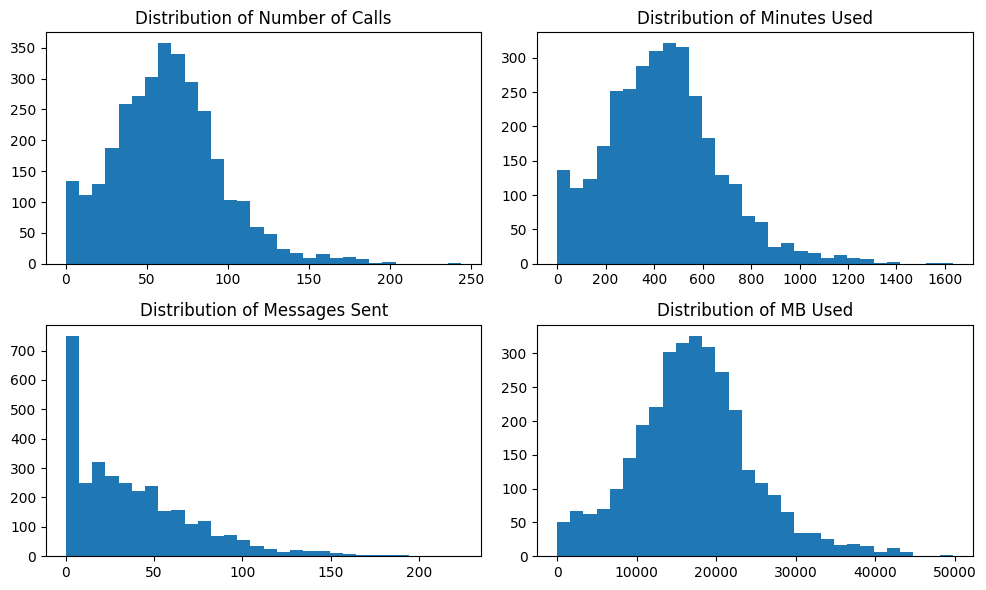

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Calls
axes[0, 0].hist(data['calls'], bins=30)
axes[0, 0].set_title('Distribution of Number of Calls')

# Minutes
axes[0, 1].hist(data['minutes'], bins=30)
axes[0, 1].set_title('Distribution of Minutes Used')

# Messages
axes[1, 0].hist(data['messages'], bins=30)
axes[1, 0].set_title('Distribution of Messages Sent')

# Internet - MB
axes[1, 1].hist(data['mb_used'], bins=30)
axes[1, 1].set_title('Distribution of MB Used')

fig.tight_layout()


plt.show()

The MB used seems to present a distribution closer to normal, compared to the other features. Both the number of calls and the minutes used present a similar distribution, which are a bit skewed to the right. The messages sent present the most skewed distribution of all. It is important to take this into consideration, since models might struggle to learn the underlying patterns when the data is skewed and might be affected by the presence of outliers. We will proceed to exclude the most extreme outliers; those that are above the 99th percentile.

In [7]:
# Calculating threshold for outliers
outliers_calls = np.percentile(data['calls'], 99)
outliers_msg = np.percentile(data['messages'], 99)
outliers_mins = np.percentile(data['minutes'], 99)
outliers_mb = np.percentile(data['mb_used'], 99)

In [8]:
# Keeping raw date intact
data_raw = data.copy()

# Excluding outliers based on the 99th percentile
data = data[(data['calls'] < outliers_calls) & 
            (data['messages'] < outliers_msg) & 
            (data['minutes'] < outliers_mins) & 
            (data['mb_used'] < outliers_mb)]

# Number of outliers excluded
data_raw.shape[0] - data.shape[0]

97

There were 97 entries exluded due to extreme values compared to the distribution of each feature. Let's also take a look at the distribution of our target variable.

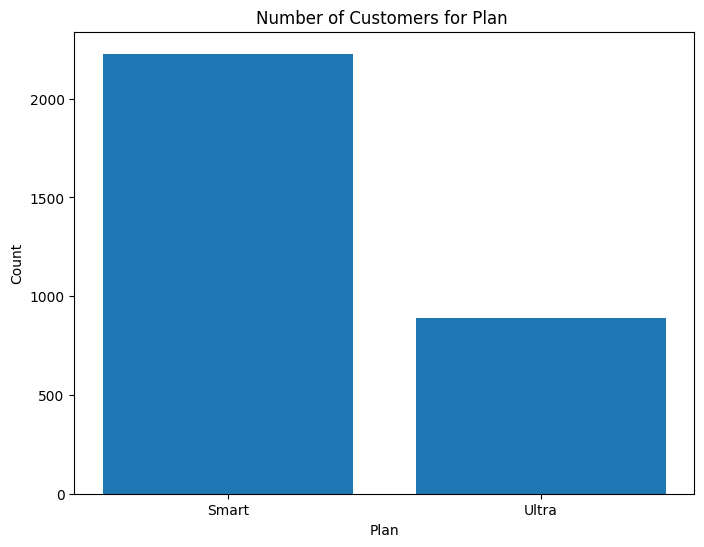

0.7147898620468399


In [9]:
selected_plan = data['is_ultra'].value_counts()
#selected_plan

# Ploting number of customers using each plan
plt.figure(figsize=(8, 6))
plt.bar(selected_plan.index, selected_plan.values)

plt.xlabel('Plan')
plt.ylabel('Count')
plt.title('Number of Customers for Plan ')
plt.xticks(selected_plan.index, ['Smart', 'Ultra'], rotation=0)

plt.show()

print(selected_plan[0]/(selected_plan[0]+selected_plan[1]))

We can see that there is a class imbalance, with a notably higher count of customers subscribed to the Smart plan compared to those on the Ultra plan. It is important to take this into consideration, since it can lead to a biased model performance, where the model might be biased towards the prediction of the plan Smart because it appears more frequently in the data.

 [⬆ Back to Contents](#back)

## Model Development <a id='develop'> </a>

Let's start by splitting the source data. Since we don't have a test set, we will split the data into three parts: training, validation and test sets, in a ratio 3:1:1. Therefore, the training set will be 60% of the data, while validation and test sets will be 20% each.

In [10]:
# Spliting training set - 60%
train_set, valid_test_set = train_test_split(data, test_size=0.4, random_state=19935)

In [11]:
# Spliting validation and test set - 20% each
valid_set, test_set = train_test_split(valid_test_set, test_size=0.5, random_state=19935)

In [12]:
# Print lengths and percentages of dfs
print(f'Training set size: {len(train_set)} rows ≈ {len(train_set)/len(data):.1f}%')
print(f'Validation set size: {len(valid_set)} rows ≈ {len(valid_set)/len(data):.1f}%')
print(f'Test set size: {len(test_set)} rows ≈ {len(test_set)/len(data):.1f}%')

Training set size: 1870 rows ≈ 0.6%
Validation set size: 623 rows ≈ 0.2%
Test set size: 624 rows ≈ 0.2%


Since we're training our model to predit which plan fit our customers better, we will train multiple classification models. For this, we will first separate our features and target into different variables.

In [13]:
# Separating features and target = training set
train_features = train_set.drop(['is_ultra'], axis=1)
train_target = train_set['is_ultra']

# Separating features and target = validation set
valid_features = valid_set.drop(['is_ultra'], axis=1)
valid_target = valid_set['is_ultra']

# Separating features and target = test set
test_features = test_set.drop(['is_ultra'], axis=1)
test_target = test_set['is_ultra']

Next, we will train a decision tree model and tune the hyperparameters.

In [14]:
# Initializing hyperparameters
best_depth_tree = None
best_score_tree = 0

# Train and tune decision tree
for depth in range(1,11):
    decision_tree = DecisionTreeClassifier(random_state=19935, max_depth=depth)
    decision_tree.fit(train_features, train_target)
    
    valid_predictions = decision_tree.predict(valid_features)
    score = accuracy_score(valid_target, valid_predictions)
    
    if score > best_score_tree:
        best_score_tree = score
        best_depth_tree = depth
        
print(f'For a depth of {best_depth_tree}, the validation accuracy is {best_score_tree:.4f}.')

For a depth of 8, the validation accuracy is 0.7817.


A decision tree model with depth 8 seems to yield the best results. Let's see how a Random Forest model performs.

In [15]:
# Initializing hyperparameters
best_estimator_forest = 0
best_depth_forest = None
best_score_forest = 0
best_split_forest = 0

# Train and tune random forest
for est in range(10, 100, 10):
    for depth in range(1, 11):
        for split in range(2, 11, 2):
            
            random_forest = RandomForestClassifier(random_state=19935, n_estimators=est, max_depth=depth, min_samples_split=split)
            random_forest.fit(train_features, train_target)
            
            valid_predictions = random_forest.predict(valid_features)
            score = accuracy_score(valid_target, valid_predictions)
            
            if score > best_score_forest:
                best_score_forest = score
                best_estimator_forest = est
                best_depth_forest = depth
                best_split_forest = split
                
print(f'For a forest with {best_estimator_forest} trees, a depth of {best_depth_forest}, and a min split of {best_split_forest}, the validation accuracy is {best_score_forest:.4f}.')

For a forest with 20 trees, a depth of 10, and a min split of 2, the validation accuracy is 0.7994.


The best configuration for the Random Forest seems to have a depth of 10 and 20 estimators. Lastly, let's train a model using logistic regression and see how it performs.

In [16]:
# Initializing hyperparameters
best_C = None
best_score_logistic = 0

C_values = [0.1, 1, 10, 100]

# Train and tune logistic regression
for C in C_values:
    logistic_regression = LogisticRegression(random_state=19935, solver='liblinear', C=C, max_iter=10000)
    logistic_regression.fit(train_features, train_target)
    
    valid_predictions = logistic_regression.predict(valid_features)
    score = accuracy_score(valid_target, valid_predictions)
    
    if score > best_score_logistic:
        best_score_logistic = score
        best_C = C
    
print(f'For a C value of {best_C}, the validation accuracy is {best_score_logistic:.4f}')

For a C value of 0.1, the validation accuracy is 0.7143


From the three models, the one with the best accuracy score is the Random Forest Model, with an accuracy of 80% - higher than the threshold. This is not surprising, since Random Forest typically improves the performance of decision trees by combining several trees and making the model more robust, while also reducing overfitting.

Following the Random Forest, we have the Decision Tree, with an accuracy of 78%. It performed well, but slightly worse than the Random Forest. In the last position, we have the Logistic Regression, with an accuracy of 71%, below the threshold. This might indicate that the relationship between the features and the target variable is not purely linear.

Given that Random Forest achieved the highest accuracy, it appears to be the best model for our dataset. However, accuracy alone shouldn't be the only criterion for selecting a model. We will consider other performance metrics after testing the model with the test set.

 [⬆ Back to Contents](#back)


## Model Evaluation <a id='eval'> </a>

Now that we have trained and tuned our models, we will evaluate the best-performing one on the test set to confirm its performance.

In [17]:
# Training selected model on test set
prediction_model = RandomForestClassifier(random_state=19935, n_estimators=best_estimator_forest, max_depth=best_depth_forest, min_samples_split=best_split_forest)
prediction_model.fit(train_features, train_target)

test_predictions = prediction_model.predict(test_features)
accuracy_test = accuracy_score(test_predictions, test_target)

print(accuracy_test)

0.8157051282051282


The validation score (80%) and the test score (82%) are very close, indicating that the model's performance is consistent and even slightly better on the test compared to the validation set. This suggests that with the hyperparameters selected, the model generalizes well to unseen data. The fact that the test score is slightly higher than the validation score indicates that the model is not overfitting to the validation set.

While an accuracy score of 82% is promising and the closeness to the validation score suggests that the model is likely to perform similarly well with other datasets, it is essential to consider other metrics to ensure the model is adequate for the objectives. To provide a more comprehensive understanding of the performance of the model, and taking into account that we have a class imbalance, let's calculate precision, recall and F1 score.

In [18]:
# Evaluating metrics of Random Forest on test set
precision = precision_score(test_target, test_predictions, average='binary')
recall = recall_score(test_target, test_predictions, average='binary')
f1 = f1_score(test_target, test_predictions, average='binary')

# Print results
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.8073
Recall: 0.4835
F1 Score: 0.6048


The model has a moderate level of precision of 80%, indicating that it makes some false positive predictions (the model predicts that a customer uses the plan Ultra when the customer is actually using the plan Smart). However, out of all the cases when the customer uses plan Ultra, the model correctly identified only around 50% of them (i.e. around 50% of the predictiond are true positives).

The F1 score reflects the trade-off between precision and recall, and in this case, it suggests that the model's overall performance is somewhat balanced but not very high. The model is struggling more with recall than precision. The model is fairly good at making positive predictions that are actually correct, but there's a significant proportion of false negatives.

To sanity check our model, we need to compare it with chance. For that, we will use a dummy classifier, which serves as a baseline model that makes predictions using simple rules. In this case, the dummy classifier will predict the most frequent class to set a minimum performance benchmark that our model should surpass. Comparing the performance of our model to that of a dummy classifier can help us make sure that our model is actually learning the patterns from the data and not just getting a prediction by chance (guessing).

In [19]:
# Dummy classifier - most frequent strategy
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(train_features, train_target)
dummy_predictions = dummy.predict(valid_features)

# Dummy metrics
dummy_accuracy = accuracy_score(valid_target, dummy_predictions)
dummy_precision = precision_score(valid_target, dummy_predictions, zero_division=0)
dummy_recall = recall_score(valid_target, dummy_predictions)
dummy_f1 = f1_score(valid_target, dummy_predictions)

# Print results
print(f'Accuracy: {dummy_accuracy:.4f}')
print(f'Precision: {dummy_precision:.4f}')
print(f'Recall: {dummy_recall:.4f}')
print(f'F1 Score: {dummy_f1:.4f}')

Accuracy: 0.7175
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


The accuracy of the dummy classifier is relatively high, which makes sense in our case, given the class imbalance in our date. The dummy classifier is correctly predicting the majority class but is never prediting the minority class, resulting in a precision, recall and F1 score of 0.

Let's also compare the metrics of our model againts a dummy classifier the guesses according to the class distribution, to get a more realistic random guessing that reflects the data distribution.

In [20]:
# Dummy classifier - stratified strategy
dummy_s = DummyClassifier(strategy='stratified')
dummy_s.fit(train_features, train_target)
dummy_s_predictions = dummy_s.predict(valid_features)

# Dummy metrics
dummy_accuracy = accuracy_score(valid_target, dummy_s_predictions)
dummy_precision = precision_score(valid_target, dummy_s_predictions)
dummy_recall = recall_score(valid_target, dummy_s_predictions)
dummy_f1 = f1_score(valid_target, dummy_s_predictions)

# Print results
print(f'Accuracy: {dummy_accuracy:.4f}')
print(f'Precision: {dummy_precision:.4f}')
print(f'Recall: {dummy_recall:.4f}')
print(f'F1 Score: {dummy_f1:.4f}')

Accuracy: 0.5955
Precision: 0.2738
Recall: 0.2614
F1 Score: 0.2674


Our model outperforms the metrics of both of the dummy classifiers, indicating that it is learning from the patterns in the data and making accurate predictions that are not due to chance.

 [⬆ Back to Contents](#back)

## Conclusion <a id='conclusion'></a>

After investigating the quality of different models and tuning the hyperparameters to select the better ones, we determined that the best model for our data is Random Forest. The model's accuracy on both the validation and test sets is reasonably high, indicating that the model effectively distinguishes between the Smart and Ultra plans based on customer behavior. The precision of the model is also moderately high, indicating a relatively low false positive rate. However, the recall score is not so high, indicating that there are some users who should be recommended the Ultra plan but are being missed by the model.

The current model can be used to assist in recommending the most suitable plan to our customers based on their usage behavior. The model is a good starting point, but further improvements are advisable. Given the overall performance metrics and taking into consideration the business implications and potential consequences, we recommend conducting a pilot test to see how the model performs in a real-world setting and gather feedback from the customers. Since there is a room for improvement in the metrics, we also recommend working on improving recall without sacrificing too much precision. This might require further tuning or gatherting more data.